In [4]:
import pandas as pd
import numpy as np
import tweepy
from tweepy import OAuthHandler
import requests
import json
import time
from timeit import default_timer as timer
import math
import re
import matplotlib.pyplot as plt
%matplotlib inline

# Gathering Data

In [5]:
# Import the Twitter archive CSV file into a DataFrame
arc_df = pd.read_csv('twitter-archive-enhanced-2.csv')

In [6]:
# Download tweet image predictions TSV using the Requests library and write it to image_predictions.tsv
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('image-predictions-3.tsv', mode='wb') as file:
    file.write(response.content)
    
# Import the tweet image predictions TSV file into a DataFrame
img_df = pd.read_csv('image-predictions-3.tsv', sep='\t')

In [ ]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

In [ ]:
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [ ]:
api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = arc_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet-json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [7]:
# List of dictionaries to read tweet's JSON data line by line and later convert to a DataFrame
df_list = []
with open('tweet-json.txt', 'r') as json_file:
    for line in json_file:
        status = json.loads(line)
        
        # Append to list of dictionaries
        df_list.append({'tweet_id': status['id'],
                        'retweet_count': status['retweet_count'],
                        'favorite_count': status['favorite_count'],
                        'display_text_range': status['display_text_range']
                       })

# Create a DataFrame with tweet ID, retweet count, favorite count and display_text_range
status_df = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count', 'display_text_range'])

# Assessing Data

In [14]:
arc_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


 ***arc_df (Twitter archive) columns:***

- **tweet_id:** the unique identifier for each tweet
- **in_reply_to_status_id:** if the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s ID
- **in_reply_to_user_id:** if the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s author ID
- **timestamp:** time when this Tweet was created
- **source:** utility used to post the Tweet, as an HTML-formatted string. e.g. Twitter for Android, Twitter for iPhone, Twitter Web Client
- **text:** actual UTF-8 text of the status update
- **retweeted_status_id:** if the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s ID
- **retweeted_status_user_id:** if the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s author ID
- **retweeted_status_timestamp:** time of retweet
- **expanded_urls:** tweet URL
- **rating_numerator:** numerator of the rating of a dog. Note: ratings almost always greater than 10
- **rating_denominator:** denominator of the rating of a dog. Note: ratings almost always have a denominator of 10
- **name:** name of the dog
- **doggo:** one of the 4 dog "stage"
- **floofer:** one of the 4 dog "stage"
- **pupper:** one of the 4 dog "stage"
- **puppo:** one of the 4 dog "stage"

In [15]:
arc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [16]:
# Check how many records in arc_df whose corresponding record with same tweet_id is missing in img_df table
len(arc_df[~arc_df.tweet_id.isin(img_df.tweet_id)])

281

In [8]:
# Sort by rating_denominator values
arc_df.rating_denominator.value_counts().sort_index()

0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

In [18]:
# Sort by rating_numerator values
arc_df.rating_numerator.value_counts().sort_index()

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

In [9]:
#sort by name
arc_df.name.value_counts().sort_index(ascending=False)

very            5
unacceptable    1
this            1
the             8
such            1
               ..
Aiden           1
Adele           1
Acro            1
Ace             1
Abby            2
Name: name, Length: 957, dtype: int64

In [20]:
img_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
157,668852170888998912,https://pbs.twimg.com/media/CUg9gBvWoAAmx-2.jpg,1,golden_retriever,0.903529,True,Tibetan_mastiff,0.041497,True,kuvasz,0.022500,True
277,670842764863651840,https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg,1,microphone,0.096063,False,accordion,0.094075,False,drumstick,0.061113,False
916,701545186879471618,https://pbs.twimg.com/media/CbxjnyOWAAAWLUH.jpg,1,Border_collie,0.280893,True,Cardigan,0.112550,True,toy_terrier,0.053317,True
2000,876120275196170240,https://pbs.twimg.com/media/DCiavj_UwAAcXep.jpg,1,Bernese_mountain_dog,0.534327,True,Saint_Bernard,0.346312,True,Greater_Swiss_Mountain_dog,0.094933,True
740,687312378585812992,https://pbs.twimg.com/media/CYnS9VWW8AAeR8m.jpg,1,seat_belt,0.703561,False,Great_Dane,0.139909,True,Weimaraner,0.021112,True


***img_df (tweet image predictions) columns:***

- **tweet_id:** the unique identifier for each tweet
- **jpg_url:** dog's image URL
- **img_num:** the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images)
- **p1:** algorithm's #1 prediction for the image in the tweet
- **p1_conf:** how confident the algorithm is in its #1 prediction
- **p1_dog:** whether or not the #1 prediction is a breed of dog
- **p2:** algorithm's #2 prediction for the image in the tweet
- **p2_conf:** how confident the algorithm is in its #2 prediction
- **p2_dog:** whether or not the #2 prediction is a breed of dog
- **p3:** algorithm's #3 prediction for the image in the tweet
- **p3_conf:** how confident the algorithm is in its #3 prediction
- **p3_dog:** whether or not the #3 prediction is a breed of dog

In [21]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [5]:
status_df.sample(5)

,tweet_id,retweet_count,favorite_count,display_text_range
2070,671109016219725825,478,1225,"[0, 135]"
1929,674036086168010753,240,906,"[0, 144]"
452,818588835076603904,7126,0,"[0, 107]"
1605,685663452032069632,1656,3557,"[0, 109]"
1023,746369468511756288,1854,6637,"[0, 114]"


***status_df (tweet status) columns:***

- **id:** the unique identifier for each tweet
- **retweet_count:** number of times this Tweet has been retweeted
- **favorite_count:** indicates approximately how many times this Tweet has been liked by Twitter users
- **display_text_range:** an array of two unicode code point indices, identifying the inclusive start and exclusive end of the displayable content of the Tweet

In [6]:
status_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2354 non-null   int64 
 1   retweet_count       2354 non-null   int64 
 2   favorite_count      2354 non-null   int64 
 3   display_text_range  2354 non-null   object
dtypes: int64(3), object(1)
memory usage: 73.7+ KB


## Quality
***arc_df (Twitter archive) table***
- contains retweets and therefore, duplicates
- many *tweet_id(s)* of arc_df table are missing in img_df (image predictions) table
- erroneous datatypes (*in_reply_to_status_id, in_reply_to_user_id* and *timestamp* columns)
- unnecessary html tags in source column in place of utility name e.g. <a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>
- text column contains untruncated text instead of displayable text
- *rating_numerator* column has values less than 10 as well as some very large numbers (e.g. 1176)
- *rating_denominator* column has values other than 10
- erroneous dog names starting with lowercase characters (e.g. a, an, actually, by)
- some records have more than one dog stage
- arc_df without any duplicates (i.e. retweets) will have empty retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp columns, which can be dropped
- *breed* column should be added in arc_df table; its values based on p1_conf and p1_dog columns of img_df (image predictions) table

## Tidiness

- **combining four dog stages columns into one:** doggo, floofer, pupper and puppo columns in arc_df table should be merged into one column named "stage"

- **joing the three dataframes:** retweet_count and favorite_count columns from status_df (tweet status) table should be joined with arc_df table

# Cleaning Data

In [10]:
# Take a copy of arc_df on which the cleaning tasks will be performed
archive_clean = arc_df.copy()

### Define
- Keep only those rows in arc_df table that are original tweets and NOT retweets (i.e. retweeted_status_id column is null).
- Keep only those records in arc_df table whose tweet_id exists in img_df table.

### Code

In [11]:
# Keep only those rows in arc_df table that are original tweets and NOT retweets (i.e. retweeted_status_id column is null).
archive_clean = archive_clean[archive_clean.retweeted_status_id.isnull()]

In [12]:
# Keep only those records in arc_df table whose tweet_id exists in img_df table
archive_clean = archive_clean[archive_clean.tweet_id.isin(img_df.tweet_id)]

### Test

In [13]:
len(archive_clean[archive_clean.retweeted_status_id.isnull() == False])

0

In [14]:
len(archive_clean[~archive_clean.tweet_id.isin(img_df.tweet_id)])

0

In [10]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1994 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   1994 non-null   object 
 4   source                      1994 non-null   object 
 5   text                        1994 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               1994 non-null   object 
 10  rating_numerator            1994 non-null   int64  
 11  rating_denominator          1994 non-null   int64  
 12  name                        1994 non-null   object 
 13  doggo                       1994 

### Define 
- Drop retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp columns from arc_df table.
- Convert in_reply_to_status_id and in_reply_to_user_id to data type integer.
- Convert timestamp to datetime data type.

### Code

In [18]:
# Drop retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp columns from arc_df table
archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

In [19]:
# Convert in_reply_to_status_id and in_reply_to_user_id to data type integer.
archive_clean.in_reply_to_status_id = archive_clean.in_reply_to_status_id.fillna(0)
archive_clean.in_reply_to_user_id = archive_clean.in_reply_to_user_id.fillna(0)

archive_clean.in_reply_to_status_id = archive_clean.in_reply_to_status_id.astype(np.int64)
archive_clean.in_reply_to_user_id = archive_clean.in_reply_to_user_id.astype(np.int64)

# Convert timestamp to datetime data type
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)

### Test

In [20]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1994 non-null   int64              
 1   in_reply_to_status_id  1994 non-null   int64              
 2   in_reply_to_user_id    1994 non-null   int64              
 3   timestamp              1994 non-null   datetime64[ns, UTC]
 4   source                 1994 non-null   category           
 5   text                   1994 non-null   object             
 6   expanded_urls          1994 non-null   object             
 7   rating_numerator       1994 non-null   int64              
 8   rating_denominator     1994 non-null   int64              
 9   name                   1994 non-null   object             
 10  doggo                  1994 non-null   object             
 11  floofer                1994 non-null   object           

### Define
- Strip all html anchor tags (i.e. <a..></a>) in source column and retain just the text in between the tags.
- Convert the datatype from string to categorical.

### Code

In [16]:
# Strip all html anchor tags (i.e. <a..></a>) in source column and retain just the text in between the tags.
archive_clean.source = archive_clean.source.str.replace(r'<(?:a\b[^>]*>|/a>)', '')

# Convert the datatype from string to categorical.
archive_clean.source = archive_clean.source.astype('category')

### Test

In [17]:
archive_clean.source.value_counts()

Twitter for iPhone    1955
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

### Define
- Using the display_text_range of status_df table, extract displayable text from text column

### Code

In [21]:
# Using the display_text_range of status_df table, extract displayable text from text column

# Before extraction: untruncated text of first 3 records
print(archive_clean.iloc[0].text)
print(archive_clean.iloc[1].text)
print(archive_clean.iloc[2].text)

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV
This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB


In [22]:
# merge status_df's display_text_range column to archive_clean to extract text using range values
archive_clean = pd.merge(archive_clean, status_df[['tweet_id', 'display_text_range']], on='tweet_id')

In [23]:
# using display_text_range of archive_clean, extract displayable text
for i, row in archive_clean.iterrows():
    text_range = row.display_text_range
    display_text = row.text[text_range[0]:text_range[1]]
    archive_clean.at[i, 'text'] = display_text

In [24]:
# drop display_text_range column
archive_clean.drop('display_text_range', axis=1, inplace=True)

### Test

In [25]:
# After extraction: first 3 records now show displayable text
print(archive_clean.iloc[0].text)
print(archive_clean.iloc[1].text)
print(archive_clean.iloc[2].text)

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10
This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10
This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10


### Define
- For records whose rating_denominator is greater than 10 and divisible by 10, use the quotient as the divisor to divide the rating_numerator. 
- If the numerator turns out to be divisible (i.e. remainder=0), assign this quotient as the rating_numerator.
- For the remaining records, check if the text column contains any fraction whose denominator is 10.If it does, update the rating_denominator to 10. Additionally, update the rating_numerator with the numerator value of this fraction.

### Code

In [26]:
# regex to match fractions
pattern = "\s*(\d+([.]\d+)?([/]\d+))"

# function which will match the above pattern and return an array of fractions, if any
def tokens(x):
  return [m.group(1) for m in re.finditer(pattern, x)]

In [27]:
# iterate through all those records whose rating_denominator is not 10
for i, row in archive_clean[archive_clean.rating_denominator != 10].iterrows():
    d = row.rating_denominator
    
    # if rating_denominator is greater than 10 and divisible by 10
    if d > 10 and d%10 == 0:
        # assign divisor as the quotient
        divisor = d/10
        n = row.rating_numerator
        
        # if rating_numerator is greater than 10 and divisible by the divisor
        if n%divisor == 0:
            # reassign rating_denominator as 10
            archive_clean.at[i, 'rating_denominator'] = 10
            # reassign rating_numerator as the quotient of rating_numerator by divisor
            archive_clean.at[i, 'rating_numerator'] = int(n/divisor)
    
    # for all those records whose rating_denominator is either less than 10 or not divisible by 10
    else:
        # extract all fractions(ratings) from text using tokens function
        ratings = tokens(row.text)
        # iterate through all the fractions
        for rating in ratings:
            # if denominator of any such fraction is equal to 10
            if rating.split('/')[1] == '10':
                # reassign rating_denominator as 10
                archive_clean.at[i, 'rating_denominator'] = 10
                # reassign rating_numerator as the numerator value of this fraction
                archive_clean.at[i, 'rating_numerator'] = int(round(float(rating.split('/')[0])))
                break

### Test

In [28]:
archive_clean.rating_denominator.value_counts()

10    1993
7        1
Name: rating_denominator, dtype: int64

### Define
- For all those records whose rating numerator is either less than or equal to 10 or greater than 10 but has a very high value,check if the text contains any fraction whose denominator is 10.If it does, update the rating_numerator with the numerator value of this fraction.

### Code

In [29]:
archive_clean[(archive_clean.rating_numerator <= 10) | (archive_clean.rating_numerator > 14)].rating_numerator.value_counts().sort_index()

0         2
1         4
2        10
3        19
4        15
5        33
6        32
7        51
8        95
9       152
10      422
24        1
26        1
27        1
75        1
420       1
1776      1
Name: rating_numerator, dtype: int64

In [30]:
# for rows whose rating numerator is either less than or equal to 10 OR
# greater than 10 but has a very high value (consider greater than 14)
for i, row in archive_clean[(archive_clean.rating_numerator <= 10) | (archive_clean.rating_numerator > 14)].iterrows():
    ratings = tokens(row.text)
    for rating in ratings:        
        if rating.split('/')[1] == '10':
            n = int(round(float(rating.split('/')[0])))
            if (row.rating_numerator == 10 and n > 10) or (row.rating_numerator != 10 and n >= 10):
                archive_clean.at[i, 'rating_numerator'] = n
                break

### Test

In [31]:
archive_clean[(archive_clean.rating_numerator <= 10) | (archive_clean.rating_numerator > 14)].rating_numerator.value_counts().sort_index()

0         2
1         4
2         9
3        19
4        14
5        31
6        32
7        51
8        94
9       152
10      421
24        1
420       1
1776      1
Name: rating_numerator, dtype: int64

### Define
- Replace all lowercase values of name column with None.

### Code

In [32]:
# Replace all lowercase values of name column with None
archive_clean['name'][archive_clean['name'].str.match('[a-z]+')] = 'None'

<ipython-input-32-f1d1f8422bff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  archive_clean['name'][archive_clean['name'].str.match('[a-z]+')] = 'None'


### Test

In [33]:
archive_clean.name[archive_clean.name == 'None'].value_counts()

None    644
Name: name, dtype: int64

In [34]:
# Sort ascending by name to check if there are more names starting with a lowercase alphabet
archive_clean.name.value_counts().sort_index(ascending=False)

Zuzu     1
Zooey    1
Zoey     3
Zoe      1
Ziva     1
        ..
Aiden    1
Adele    1
Acro     1
Ace      1
Abby     2
Name: name, Length: 914, dtype: int64

In [36]:
# some records have more than one dog stage
print(len(archive_clean[(archive_clean.doggo != 'None') & (archive_clean.floofer != 'None')]))
print(len(archive_clean[(archive_clean.doggo != 'None') & (archive_clean.puppo != 'None')]))
print(len(archive_clean[(archive_clean.doggo != 'None') & (archive_clean.pupper != 'None')]))

1
1
9


### Define
- There is one record that has both doggo and floofer and another record that has both doggo and puppo. For these 2 records, take a look at the text manually to decide one dog stage for each of them. For ambiguous texts, set both the column values as None.

- There are 9 records which have both doggo and pupper. As per the dogtionary, doggo and pupper are sometimes used interchangeably. Therefore, set pupper column as None for these 9 records.

### Code

In [35]:
# There is one record that has both doggo and floofer and another record that has both doggo and puppo.set both the column values as None.
for i, row in archive_clean[((archive_clean.doggo != 'None') & (archive_clean.floofer != 'None'))
                   | ((archive_clean.doggo != 'None') & (archive_clean.puppo != 'None'))].iterrows():
    print('%s %s\n'%(row.tweet_id, row.text))

855851453814013952 Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for

854010172552949760 At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs



In [36]:
# based on the above texts, doggo should be set as None for both the records
archive_clean['doggo'][archive_clean.tweet_id.isin([855851453814013952, 854010172552949760])] = 'None'

<ipython-input-36-17da05be93ac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  archive_clean['doggo'][archive_clean.tweet_id.isin([855851453814013952, 854010172552949760])] = 'None'


In [37]:
# There are 9 records which have both doggo and pupper.set pupper column as None for these 9 records.
archive_clean['pupper'][(archive_clean.doggo != 'None') & (archive_clean.pupper != 'None')] = 'None'

<ipython-input-37-ccaeae47d035>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  archive_clean['pupper'][(archive_clean.doggo != 'None') & (archive_clean.pupper != 'None')] = 'None'


### Test

In [38]:
len(archive_clean[((archive_clean.doggo != 'None') & (archive_clean.pupper != 'None'))
                  | ((archive_clean.doggo != 'None') & (archive_clean.floofer != 'None')) 
                  | ((archive_clean.doggo != 'None') & (archive_clean.puppo != 'None'))])

0

### Define
- Merge the doggo, floofer, pupper and puppo columns to a stage column. Convert the datatype from string to categorical as it helps with analysis and visualization and saves memory on disk.

- Drop the doggo, floofer, pupper and puppo columns.

### Code

In [39]:
# Merge the doggo, floofer, pupper and puppo columns to a stage column.
archive_clean['stage'] = archive_clean[['doggo', 'floofer', 'pupper', 'puppo']].max(axis=1)

In [40]:
# convert the datatype from string to categorical
archive_clean.stage = archive_clean.stage.astype('category')

In [41]:
# drop the doggo, floofer, pupper and puppo columns
archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

### Test

In [42]:
archive_clean.stage.value_counts()

None       1688
pupper      203
doggo        72
puppo        23
floofer       8
Name: stage, dtype: int64

In [45]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1994 non-null   int64              
 1   in_reply_to_status_id  1994 non-null   int64              
 2   in_reply_to_user_id    1994 non-null   int64              
 3   timestamp              1994 non-null   datetime64[ns, UTC]
 4   source                 1994 non-null   category           
 5   text                   1994 non-null   object             
 6   expanded_urls          1994 non-null   object             
 7   rating_numerator       1994 non-null   int64              
 8   rating_denominator     1994 non-null   int64              
 9   name                   1994 non-null   object             
 10  stage                  1994 non-null   category           
dtypes: category(2), datetime64[ns, UTC](1), int64(5), object

### Define
- Create breed, retweet_count and favorite_count columns in arc_df table. For each tweet_id, use the img_df table to check if p1_conf is greater than 0.95 (i.e. 95% confidence interval) and p1_dog is True. If it is, set the value of p1 column in breed column.

- Also, fetch the retweet_count and favorite_count columns of status_df table and assign those values to arc_df table

### Code

In [43]:
# create breed, retweet_count and favorite_count columns
archive_clean['breed'] = 'None'
archive_clean['retweet_count'] = 0
archive_clean['favorite_count'] = 0

In [44]:
# iterate through all the rows of archive_clean
for i, row in archive_clean.iterrows():
    # fetch the retweet_count and favorite_count columns of status_df table and assign those values
    archive_clean.at[i, 'retweet_count'] = status_df[status_df.tweet_id == row.tweet_id].retweet_count.iloc[0]
    archive_clean.at[i, 'favorite_count'] = status_df[status_df.tweet_id == row.tweet_id].favorite_count.iloc[0]    
    
    img_prediction = img_df[img_df.tweet_id == row.tweet_id]
    p1_conf = img_prediction.p1_conf.iloc[0]
    p1_dog = img_prediction.p1_dog.iloc[0]
    #  check if p1_conf is greater than 0.95 (i.e. 95% confidence interval) and p1_dog is True
    if p1_conf >= 0.95 and p1_dog:
        archive_clean.at[i, 'breed'] = img_prediction.p1.iloc[0]

### Test

In [49]:
archive_clean.breed.value_counts()

None                           1808
pug                              20
Pembroke                         19
Samoyed                          19
golden_retriever                 16
Pomeranian                       13
Labrador_retriever                9
Chihuahua                         9
French_bulldog                    8
chow                              7
German_shepherd                   4
Bernese_mountain_dog              4
Shetland_sheepdog                 4
beagle                            3
Blenheim_spaniel                  3
Pekinese                          3
Old_English_sheepdog              3
malamute                          2
keeshond                          2
basset                            2
Boston_bull                       2
bull_mastiff                      2
cocker_spaniel                    2
vizsla                            2
dalmatian                         2
Shih-Tzu                          2
komondor                          2
English_springer            

In [45]:
archive_clean[['tweet_id', 'retweet_count', 'favorite_count']].sample(5)

,tweet_id,retweet_count,favorite_count
1080,701214700881756160,5812,13475
360,814153002265309185,10080,32000
1863,668466899341221888,560,936
446,796149749086875649,16628,36177
171,849776966551130114,8404,32390


In [53]:
archive_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,breed,retweet_count,favorite_count
1020,707014260413456384,0,0,2016-03-08 01:25:10+00:00,Twitter for iPhone,This is Ellie. She requests to be carried arou...,https://twitter.com/dog_rates/status/707014260...,11,10,Ellie,,None,664,2502
463,793241302385262592,0,0,2016-11-01 00:00:38+00:00,Twitter for iPhone,This is Tucker. He's out here bustin h*ckin gh...,https://twitter.com/dog_rates/status/793241302...,13,10,Tucker,,None,3812,11780
902,719991154352222208,0,0,2016-04-12 20:50:42+00:00,Twitter for iPhone,This doggo was initially thrilled when she saw...,https://twitter.com/dog_rates/status/719991154...,10,10,None,doggo,None,1979,5281
215,839239871831150596,0,0,2017-03-07 22:22:32+00:00,Twitter for iPhone,This is Odie. He's big. 13/10 would attempt to...,https://twitter.com/dog_rates/status/839239871...,13,10,Odie,,None,7422,29684
82,872820683541237760,0,0,2017-06-08 14:20:41+00:00,Twitter for iPhone,Here are my favorite #dogsatpollingstations \n...,https://twitter.com/dog_rates/status/872820683...,13,10,None,,pug,3884,15029


# Storing Data

In [51]:
archive_clean.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

# Analyzing Data

In [52]:
# For analysis, create a copy of the cleaned twitter archive data
df = archive_clean.copy()

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1994 non-null   int64              
 1   in_reply_to_status_id  1994 non-null   int64              
 2   in_reply_to_user_id    1994 non-null   int64              
 3   timestamp              1994 non-null   datetime64[ns, UTC]
 4   source                 1994 non-null   category           
 5   text                   1994 non-null   object             
 6   expanded_urls          1994 non-null   object             
 7   rating_numerator       1994 non-null   int64              
 8   rating_denominator     1994 non-null   int64              
 9   name                   1994 non-null   object             
 10  stage                  1994 non-null   category           
 11  breed                  1994 non-null   object           

In [54]:
# Analyzing number of tweets posted by WeRateDogs' over time
df['timestamp'].apply(lambda x: x.strftime('%Y-%m')).value_counts().sort_index()

2015-11    296
2015-12    367
2016-01    169
2016-02    111
2016-03    120
2016-04     54
2016-05     57
2016-06     81
2016-07     88
2016-08     59
2016-09     63
2016-10     65
2016-11     53
2016-12     54
2017-01     66
2017-02     64
2017-03     48
2017-04     41
2017-05     43
2017-06     44
2017-07     49
2017-08      2
Name: timestamp, dtype: int64

In [55]:
# Most used Twitter source
df['source'].value_counts()

Twitter for iPhone    1955
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

In [56]:
# Analysis of dog breed (as identified by image prediction)
df['breed'][df['breed'] == 'None'].value_counts()

None    1808
Name: breed, dtype: int64

The breed of **1808** dogs out of **1994** (i.e. 90%) couldn't be predicted. So, at 95% confidence interval, the image prediction algorithm was able to predict the breed for **10%** of the dog population of this data set.

In [57]:
# Analysis of retweet and favorite counts
print('%s\t%s' % ('Mean Retweet Count', round(df.retweet_count.mean())))
print('%s\t%s' % ('Mean Favorite Count', round(df.favorite_count.mean())))

Mean Retweet Count	2767
Mean Favorite Count	8896


In [58]:
# Analysis of retweet and favorite counts When the dog is rated greater than 10
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.rating_numerator > 10].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.rating_numerator > 10].mean())))

Mean Retweet Count	3840
Mean Favorite Count	12779


In [59]:
# Analysis of retweet and favorite counts Categorized on dog-stage

print('Doggo')
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.stage == 'doggo'].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.stage == 'doggo'].mean())))

print('Floofer')
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.stage == 'floofer'].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.stage == 'floofer'].mean())))

print('Pupper')
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.stage == 'pupper'].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.stage == 'pupper'].mean())))

print('Puppo')
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.stage == 'puppo'].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.stage == 'puppo'].mean())))

Doggo
Mean Retweet Count	6745
Mean Favorite Count	18503
Floofer
Mean Retweet Count	4777
Mean Favorite Count	13701
Pupper
Mean Retweet Count	2364
Mean Favorite Count	7198
Puppo
Mean Retweet Count	7027
Mean Favorite Count	22724


In [60]:
df.name.value_counts()

None       644
Charlie     11
Cooper      10
Lucy        10
Oliver      10
          ... 
Duddles      1
Nico         1
Dante        1
General      1
Duchess      1
Name: name, Length: 914, dtype: int64

# Visualizing Data

In [61]:
plt.rcParams["figure.figsize"] = [12, 9]

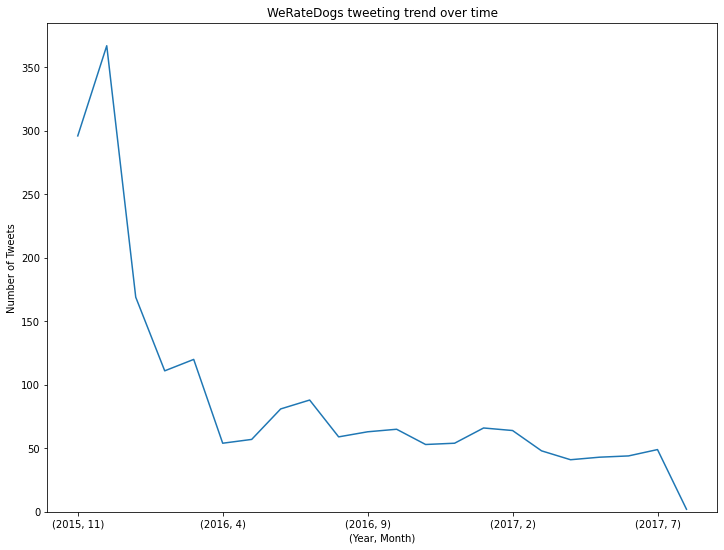

In [63]:
data = df.tweet_id.groupby([df["timestamp"].dt.year, df["timestamp"].dt.month]).count()
ax = data.plot(kind ='line', title='WeRateDogs tweeting trend over time')
ax.set_xlabel("(Year, Month)")
ax.set_ylabel("Number of Tweets")
ax.set_ylim(0, )
plt.savefig('tweet_trend')

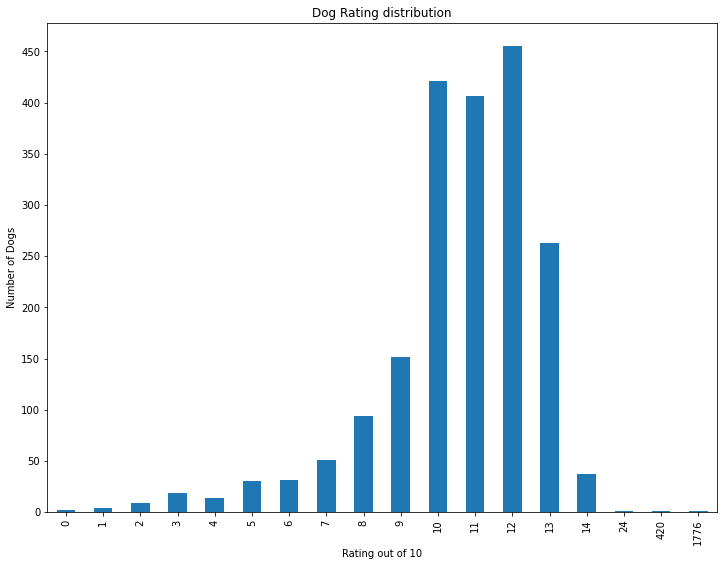

In [64]:
ax = df.rating_numerator.value_counts().sort_index().plot(kind ='bar', title = 'Dog Rating distribution')
ax.set_xlabel("Rating out of 10")
ax.set_ylabel("Number of Dogs")
ax.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450])
plt.savefig('rating_dist')

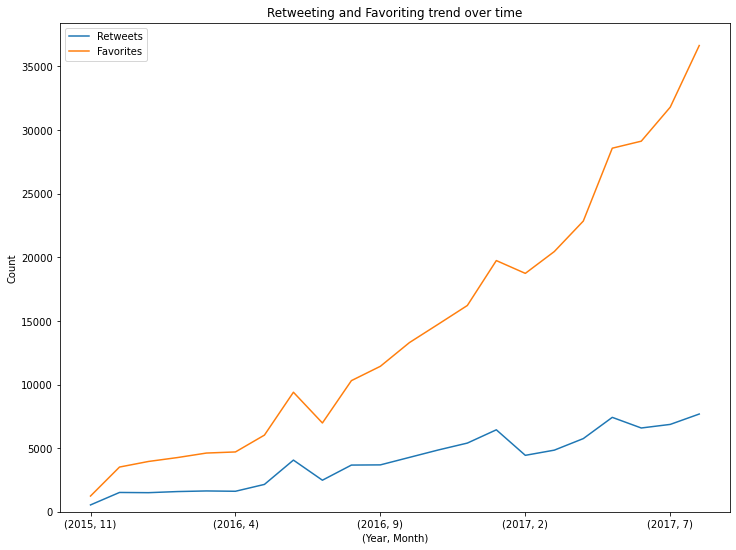

In [66]:
plt.subplots(1, sharex=True)
df.retweet_count.groupby([df["timestamp"].dt.year, df["timestamp"].dt.month]).mean().plot(kind ='line')
df.favorite_count.groupby([df["timestamp"].dt.year, df["timestamp"].dt.month]).mean().plot(kind ='line').set_ylim(0, )
plt.title('Retweeting and Favoriting trend over time')
plt.ylabel('Count')
plt.xlabel('(Year, Month)')
plt.legend(('Retweets', 'Favorites'))
plt.savefig('ret_fav')

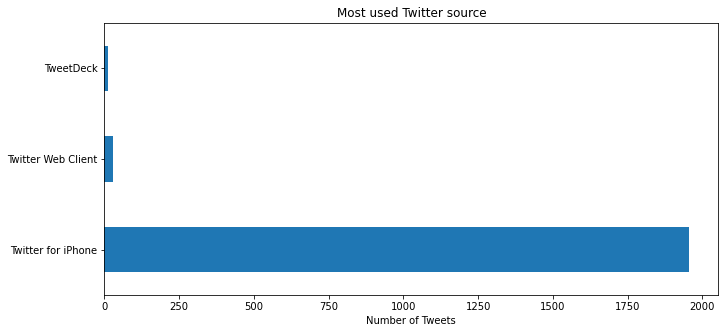

In [68]:
df['source'].value_counts().plot(kind = 'barh', figsize=(11,5), title='Most used Twitter source').set_xlabel("Number of Tweets")
plt.savefig('twitter_source')

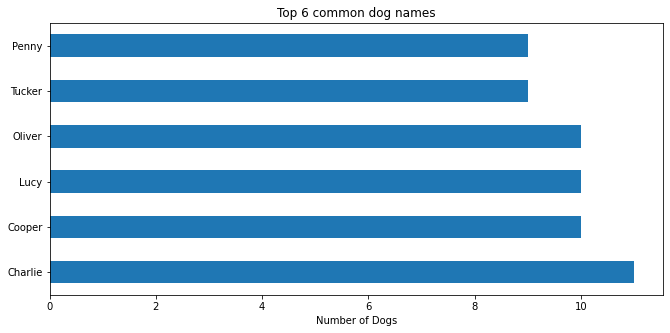

In [70]:
df.name.value_counts()[1:7].plot(kind = 'barh', figsize=(11,5), title='Top 6 common dog names').set_xlabel("Number of Dogs")
plt.savefig('dog_names')